In [175]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import pyext.src.lpdf as lpdf
import pyext.src.lpmf as lpmf
import pyext.src.matrix as mat
import pyext.src.pynet_rng as rng
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations, permutations
from functools import partial
from collections import namedtuple

In [80]:
def select(nodes, A):
    p = len(nodes)
    B = np.zeros((p, p))
    for i in range(p):
        for j in range(i, p):
            if i < j:
                u = nodes[j]
                v = nodes[i]
                print(j, i, u, v)
                B[j, i] = A[u, v]
    return B

def projectAtog1(A):
    B = jnp.zeros((p1, p1))
    val = A[(2, 4, 6, 4, 6, 6), (0, 0, 0, 2, 2, 4)]
    B = B.at[(1, 2, 3, 2, 3, 3), (0, 0, 0, 1, 1, 2)].set(val)
    B = B + B.T
    B = B.at[(0, 1, 2, 3), (0, 1, 2, 3)].set(A[g1, g1])
    return B

def projectAtog2(A):
    B = jnp.zeros((p2, p2))
    val = A[(4, 5, 6, 7, 5, 6, 7, 6, 7, 7), (3, 3, 3, 3, 4, 4, 4, 5, 5, 6)]
    B = B.at[(1, 2, 3, 4, 2, 3, 4, 3, 4, 4), (0, 0, 0, 0, 1, 1, 1, 2, 2, 3)].set(val)
    B = B + B.T
    B = B.at[(0, 1, 2, 3 ,4), (0, 1, 2, 3, 4)].set(A[g2, g2])
    return B


def norm_squares(S):
    """
    vector norm elementwise
    """
    n = jnp.mean(jnp.sqrt(jnp.power(S, 2)))
    return S / n

def d(S, A):
    return jnp.mean(jnp.sqrt(jnp.power(S - A, 2)))

split = jax.random.split
inv = jnp.linalg.inv

In [48]:
# Generate Synthetic data and ground truth
p = 8
rseed = 13
Atrue = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 0, 0, 0, 0, 0, 0, 0],
                  [1, 0, 0, 0, 0, 0, 0, 0],
                  [1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 1, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 1, 0, 0, 0],
                  [0, 1, 0, 0, 0, 1, 1, 0],
                 ])

npos = jnp.sum(Atrue)
m = 8 * (8 - 1) // 2
nneg = m - npos
p1 = 4
p2 = 5

c1 = 37392
c2 = 2893921

data_mu1 = jnp.ones(p1) * c1
data_mu2 = jnp.ones(p2) * c2

Atrue = Atrue + Atrue.T
Atrue[np.diag_indices(p)] = 1

tril1 = jnp.tril_indices(p1, k=-1) 
tril2 = jnp.tril_indices(p2, k=-1)
diag1 = jnp.diag_indices(p1)
diag2 = jnp.diag_indices(p2)

In [160]:
g0 = (0, 1, 2, 3, 4, 5, 6, 7)
g1 = (0, 2, 4, 6)
g2 = (3, 4, 5, 6, 7)

data_prec1 = projectAtog1(Atrue) * (1 / c1)
data_prec2 = projectAtog2(Atrue) * (1 / c2)

data_prec1 = data_prec1.at[diag1].set(100 / c1)
data_prec2 = data_prec2.at[diag2].set(100 / c2)

key = jax.random.PRNGKey(rseed)
key, k1, k2 = split(key, 3)

assert mat.is_positive_definite(data_prec1)
assert mat.is_positive_definite(data_prec2)

y1 = jax.random.multivariate_normal(k1, data_mu1, inv(data_prec1), shape=(3,))
y2 = jax.random.multivariate_normal(k2, data_mu2, inv(data_prec2), shape=(3,))

assert y1.shape == (3, p1)
assert y2.shape == (3, p2)


# Define degrees of freedom

nsolutions = 2**m
A = jnp.eye(p)
alpha = 2
beta = 2

cov1 = jnp.eye(p1)
cov2 = jnp.eye(p2)


assert len(g1) == p1
assert len(g2) == p2
b1 = 1
b2 = 0

nu1 = p1
nu2 = p2

V1 = 1/nu1 * (inv(y1.T @ y1 + jnp.mean(y1.T @ y1) * np.eye(p1)))

V2 = jnp.ones((p2, p2))
V2 = V2 * 1e-7
V2 = V2.at[diag2].set(4*1e-7)
V2 = (1/nu2) * V2
assert mat.is_positive_definite(V1)
assert mat.is_positive_definite(V2)

In [187]:
# Generate synthetic data

data1 = jax.random.multivariate_normal

position = {'g0': {'A': A, 'alpha': alpha, 'beta': beta},
           'p1': {
                 'cov': cov1,
                 'mu':  data_mu1,
                 'y': y1,
                 'nu': nu1,
                 'V': V1
            },
            'p2': {
                 'cov': cov2,
                 'mu':  data_mu2,
                 'y': y2,
                 'nu': nu2,
                 'V': V2
            },
            'g1': {'idx': (0, 1, 2, 4, 6)},
            'g2': {'idx': (0, 3, 4, 5, 6, 7)}
           }


# Define Scoring Function

def lbetabinom(position):
    # p(A| alpha, beta)
    tril_idx = np.tril_indices(p, k=-1)
    alpha = position['g0']['alpha']
    beta = position['g0']['beta']
    d = position['g0']
    A = d['A']
    k = jnp.sum(A[tril_idx])
    return lpmf.betabinom(k, m, alpha, beta)

    
def yscore(position, scope):
    mu = position[scope]['mu']
    cov = position[scope]['cov']
    y1 = position[scope]['y']
    
    ya = y1[0, :]
    yb = y1[1, :]
    yc = y1[2, :]
    
    s1 = lpdf.multivariate_normal(ya, mu, cov)
    s2 = lpdf.multivariate_normal(yb, mu, cov)
    s3 = lpdf.multivariate_normal(yc, mu, cov)
    
    return s1 + s2 + s3

y1score = partial(yscore, scope='p1')
y2score = partial(yscore, scope='p2')

def d1score(position):
    A = position['g0']['A']
    cov1 = position['p1']['cov']
    prec1 = inv(cov1)
    A1 = projectAtog1(A)
    d1 = d(prec1, A1)
    
    # lambda = 1
    # logpdf = ln(1)-1 *x = -x
    return -d1

def d2score(position):
    A = position['g0']['A']
    cov = position['p2']['cov']
    prec = inv(cov)
    A2 = projectAtog2(A)
    d2 = d(prec, A2)
    
    # lambda = 1
    # logpdf = ln(1)-1 *x = -x
    return -d2
    
def model_score(position):
    s1 = lbetabinom(position)
    s2 = y1score(position)
    s3 = y2score(position)
    s4 = d1score(position)
    s5 = d2score(position)
    
    return jnp.array([s1, s2, s3, s4, s5])
    
def log_score(position):
    return jnp.sum(model_score(position))
# Define Movers

def move_A0(key, position):
    k0, k1 = split(key, 2)
    row = jax.random.randint(k0, shape=(1,), minval=1, maxval=p)
    col = 0
    value = jax.random.randint(k1, shape=(1,), minval=0, maxval=2)
    
    A = position['g0']['A']
    A = A.at[row, col].set(value)
    A = A.at[col, row].set(value)
    position['g0']['A'] = A
    return position
    

def move_A(key, position):
    A = position['g0']['A']
    k0, k1, k3 = split(key, 3)
    
    col = jax.random.randint(k0, shape=(1,), minval=1, maxval=p)
    row = jax.random.randint(k1, shape=(1,), minval=col+1, maxval=p)
    value = jax.random.randint(k3, shape=(1,), minval=0, maxval=2)
    
    A = A.at[row, col].set(value)
    A = A.at[col, row].set(value)
    
    position['g0']['A'] = A
    
    return position

def move_wish(key, p, nu, V):
    w = rng.wishart(key=key, p=p, nu=nu, V=V)
    return w

def move_cov1(key, position):
    V = position['p1']['V']
    nu = position['p1']['nu']
    s = rng.wishart(key=key, p = p1, n=nu, V=V)
    cov = inv(s)
    
    position['p1']['cov1'] = cov
    return position

def move_cov2(key, position):
    V = position['p2']['V']
    nu = position['p2']['nu']
    s = rng.wishart(key=key, p = p2, n=nu, V=V)
    cov = inv(s)
    position['p1']['cov1'] = cov
    return position


def move_model(key, position):
    
    k1, k2, k3, k4 = jax.random.split(key, 4)
    position = move_A0(k1, position)
    position = move_A(k2, position)
    position = move_cov1(k3, position)
    position = move_cov2(k4, position)
    return position



    
SampleParams = namedtuple("SampleParams",
"nmc_steps step T key accepted")

SampleState = namedtuple("SampleState",
                        "position params")
    
# Define Sampling

def init_sampling_state(position, sample_params):
    return SampleState(position, sample_params)
    

def update_sampling_state(sample_state):
    
    def accept_branch(v):
        x0, x1, _ = v
        return x1, x1, True
        

    def reject_branch():
        x0, x1, _ = v
        return x0, x0, True
    
    return sample_state
    k0, k1, k2, k3 = split(sample_state.params.key, 4)
    x0 = sample_state.position
    
    x1 = move_model(k1, sample_state.position)
    
    s0 = log_score(x0)
    s1 = log_score(x1)
    
    log_alpha = s1 - s0 
    
    alpha = jnp.exp(log_alpha)
    
    u = jax.random.uniform(k0, minval=0, maxval=1)
    
    # Accept
    
    accepted = False
    x_update, _, accepted = jax.lax.cond(u <= alpha, accept_branch, reject_branch, (x0, x1, accepted))
    
    # update sample params
    
    params = sample_state.params
    nmc_steps = params.nmc_steps
    step = params.step + 1
    T = params.T
    key = k3
    params = SampleParams(nmc_steps=nmc_steps,
                          step=step,
                          T=T,
                          key=key,
                          accepted=accepted)
    
    # update sample state
    
    sample_state = SampleState(position=x_update,
                               params=params)
    

    

# Sample alternative models

# Report

In [313]:

def dosaves(val):

    
    InfState = namedtuple("InfState",
           "scores accepteds As Sigma1s Sigma2s step saveindex")
    state, infstate = val
    saveindex = infstate.saveindex
    
    A = state.position['g0']['A']
    cov1 = state.position['p1']['cov']
    cov2 = state.position['p2']['cov']
    
    As = infstate.As
    Sigma1s = infstate.Sigma1s
    Sigma2s = infstate.Sigma2s
    
    As = As.at[saveindex, :, :].set(A)
    Sigma1s = Sigma1s.at[saveindex, :, :].set(cov1)
    Sigma2s = Sigma2s.at[saveindex, :, :].set(cov2)
    

    saveindex = saveindex
    saveindex = saveindex + 1
    scores = InfState.scores
    step = infstate.step
    step = step + 1
    accepteds = infstate.accepteds
    
    updated = InfState(scores, accepteds, As, Sigma1s, Sigma2s, step, saveindex)
    val = state, updated
    return val

def dontsave(val):
    InfState = namedtuple("InfState",
           "scores accepteds As Sigma1s Sigma2s step saveindex")
    state, infstate = val
    step = infstate.step
    step = step + 1
    scores = infstate.scores
    accepteds = infstate.accepteds
    As = infstate.As
    Sigma1s = infstate.Sigma1s
    Sigma2s = infstate.Sigma2s
    saveindex = infstate.saveindex

    infstate = InfState(scores, accepteds, As, Sigma1s, Sigma2s, step, saveindex)
    val = state, infstate
    return val

def init_inference(nsteps, save_position_every):
    scores = jnp.zeros(nsteps)
    accepteds = jnp.zeros(nsteps)
    
    nsaves = nsteps // save_position_every
    
    As = jnp.zeros((nsaves, p, p))
    Sigma1s = jnp.zeros((nsaves, p1, p1))
    Sigma2s = jnp.zeros((nsaves, p2, p2))
    return (scores,
           accepteds,
           nsaves,
           As,
           Sigma1s,
           Sigma2s)

def init_inference_state(nsteps, save_position_every):
    scores, accepteds, nsaves, As, Sigma1s, Sigma2s = init_inference(nsteps, save_position_every)
    return InfState(scores, accepteds, As, Sigma1s, Sigma2s, 0, 0)

InfState = namedtuple("InfState",
           "scores accepteds As Sigma1s Sigma2s step saveindex")
def do_inference(init_state, update_fun, nsteps, save_position_every):
    
    # save the score, position, every save_every
    
    scores, accepteds, nsaves, As, Sigma1s, Sigma2s = init_inference(nsteps, save_position_every)
    init_infstate = InfState(scores, accepteds, As, Sigma1s, Sigma2s, 0, 0)

    def body(i, val):
        state, infstate = val
        step = infstate.step
        notsave = step % nsaves

        val = state, infstate

        scratch, updated_infstate = jax.lax.cond(notsave==False,
                                       dosaves,
                                       dontsave,
                                       val)

        updated_state = update_fun(state)
        val = updated_state, updated_infstate

        return val
    val = init_state, init_infstate
    return jax.lax.fori_loop(0, nsteps, body, val)
    

In [306]:
key = jax.random.PRNGKey(12983)
sample_params = SampleParams(nmc_steps=1000,
                            step=0,
                            T=2,
                            key=key,
                            accepted=False)
sample_state = init_sampling_state(position, sample_params)


inference_loop = partial(do_inference, update_fun=update_sampling_state,
                        nsteps=sample_params.nmc_steps, save_position_every=100)

In [366]:
def dosaves(val):
    InfState = namedtuple("InfState",
           "scores accepteds As Sigma1s Sigma2s step saveindex")
    state=val[0]
    infstate=val[1]
    
    saveindex = infstate[6]#.saveindex
    
    A = state.position['g0']['A']
    cov1 = state.position['p1']['cov']
    cov2 = state.position['p2']['cov']
    
    As = infstate[2]#.As
    Sigma1s = infstate[3]#.Sigma1s
    Sigma2s = infstate[4]#.Sigma2s
    
    As = As.at[saveindex, :, :].set(A)
    Sigma1s = Sigma1s.at[saveindex, :, :].set(cov1)
    Sigma2s = Sigma2s.at[saveindex, :, :].set(cov2)
    
    
    saveindex = saveindex
    saveindex = saveindex + 1
    scores = infstate.scores
    step = infstate.step
    step = step + 1
    accepteds = infstate.accepteds
    
    infstate = (scores, accepteds, As, Sigma1s, Sigma2s, step, saveindex)
    
    val = state, infstate
    
    return val

init_infstate = init_inference_state(1000, 100)
assert init_infstate.As.shape == (10, p, p)
assert init_infstate.Sigma1s.shape == (10, p1, p1)
assert init_infstate.Sigma2s.shape == (10, p2, p2)


inftuple = tuple(init_infstate)

jax.jit(dosaves)((sample_state, inftuple))

AttributeError: 'tuple' object has no attribute 'step'

0

2

In [310]:
init_infstate.As.shape

(10, 8, 8)

In [294]:
jax.jit(dontsave)((sample_state, init_infstate))

(SampleState(position={'g0': {'A': DeviceArray([[1., 0., 0., 0., 0., 0., 0., 0.],
              [0., 1., 0., 0., 0., 0., 0., 0.],
              [0., 0., 1., 0., 0., 0., 0., 0.],
              [0., 0., 0., 1., 0., 0., 0., 0.],
              [0., 0., 0., 0., 1., 0., 0., 0.],
              [0., 0., 0., 0., 0., 1., 0., 0.],
              [0., 0., 0., 0., 0., 0., 1., 0.],
              [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32), 'alpha': DeviceArray(2, dtype=int32, weak_type=True), 'beta': DeviceArray(2, dtype=int32, weak_type=True)}, 'g1': {'idx': (DeviceArray(0, dtype=int32, weak_type=True), DeviceArray(1, dtype=int32, weak_type=True), DeviceArray(2, dtype=int32, weak_type=True), DeviceArray(4, dtype=int32, weak_type=True), DeviceArray(6, dtype=int32, weak_type=True))}, 'g2': {'idx': (DeviceArray(0, dtype=int32, weak_type=True), DeviceArray(3, dtype=int32, weak_type=True), DeviceArray(4, dtype=int32, weak_type=True), DeviceArray(5, dtype=int32, weak_type=True), DeviceArray(6, dtype

In [273]:
inference_loop(sample_state)

TypeError: Value _tuplegetter(0, 'Alias for field number 0') with type <class '_collections._tuplegetter'> is not a valid JAX type

In [280]:
val = sample_state, init_infstate
jax.lax.cond(0, dosaves, dontsave, val)

TypeError: Value _tuplegetter(0, 'Alias for field number 0') with type <class '_collections._tuplegetter'> is not a valid JAX type

(DeviceArray(0, dtype=int32, weak_type=True),
 DeviceArray(1, dtype=int32, weak_type=True))

In [268]:
def ftest(x):
    mytupe = namedtuple("X", 'x, y')
    return mytupe(x, 0)

X(x=DeviceArray(0, dtype=int32, weak_type=True), y=DeviceArray(0, dtype=int32, weak_type=True))

In [173]:
jax.random.uniform(key, minval=0, maxval=1)

DeviceArray(0.2835287, dtype=float32)

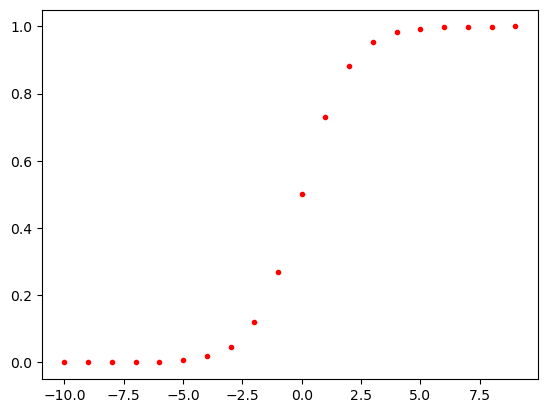

In [69]:
x = jnp.arange(-10, 10)
y = jsp.stats.logistic.cdf(x)
plt.plot(x, y, 'r.')

In [126]:
s = 0
for i in range(100):
    ky = jax.random.PRNGKey(i)
    s += jax.random.randint(ky, shape=(1,), minval=0, maxval=1)
print(s)

[0]


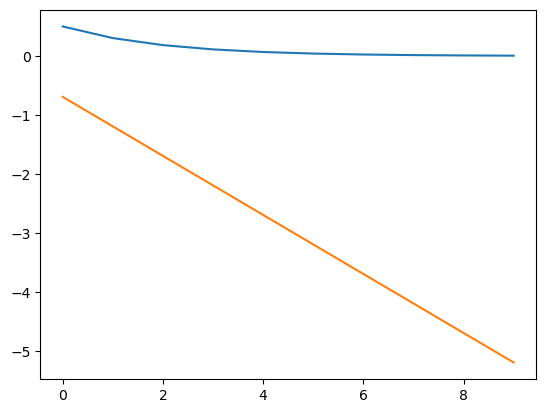

In [88]:
# exponential distribution
x = jnp.arange(0, 10)
ypdf = jsp.stats.expon.pdf(x, scale=2)
ylpdf = jsp.stats.expon.logpdf(x, scale=2)
plt.plot(x, ypdf)
plt.plot(x, ylpdf)

In [96]:
inv(y2 @ y2.T)

DeviceArray([[-3.28456906e-07, -2.33308128e-09,  3.30800049e-07],
             [ 8.64975149e-08,  1.21117594e-07, -2.07623344e-07],
             [ 2.41965324e-07, -1.18790055e-07, -1.23177088e-07]],            dtype=float32)

In [45]:
projectAtog1(Atrue).at[jnp.diag_indices(p1)].set(2)

DeviceArray([[2., 1., 0., 0.],
             [1., 2., 0., 1.],
             [0., 0., 2., 1.],
             [0., 1., 1., 2.]], dtype=float32)

In [75]:
norm_squares(data_prec1)

DeviceArray([[3.9408867 , 0.03940887, 0.        , 0.        ],
             [0.03940887, 3.9408867 , 0.        , 0.03940887],
             [0.        , 0.        , 3.9408867 , 0.03940887],
             [0.        , 0.03940887, 0.03940887, 3.9408867 ]],            dtype=float32)

In [14]:
# scratch
'{:,}'.format(nsolutions)

'268,435,456'

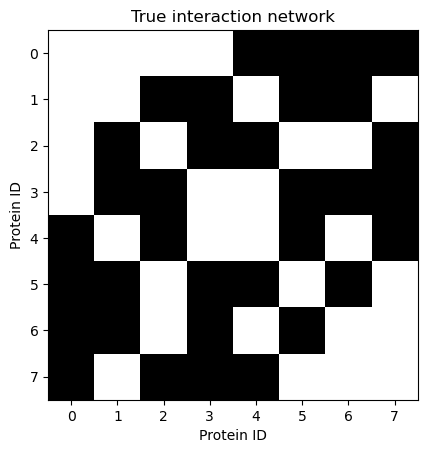

In [88]:
plt.title("True interaction network")
plt.xlabel("Protein ID")
plt.ylabel("Protein ID")
plt.imshow(Atrue, 'bone')

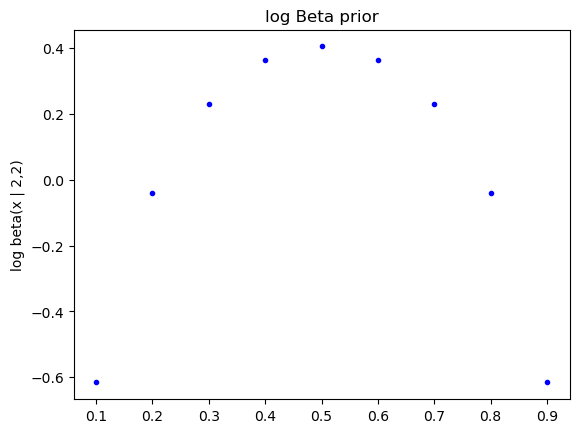

In [48]:
# Make some plots of model assumptions
x = np.arange(0, 1, 0.1)
y = lpdf.beta(x, alpha, beta)
plt.title("log Beta prior")
plt.ylabel(f"log beta(x | {alpha},{beta})")
plt.plot(x, y, 'b.')

Text(0.5, 0, 'k-edges out of 28 possible pairs')

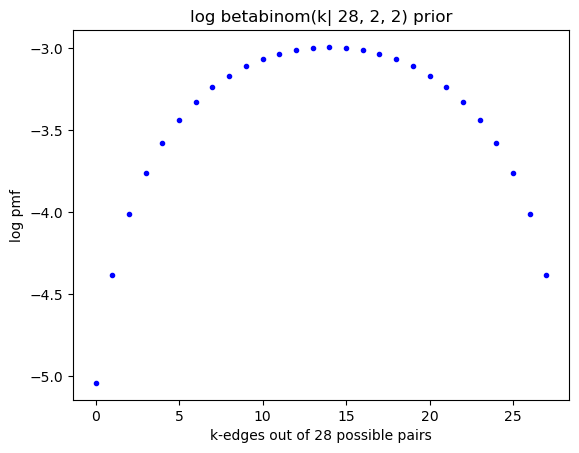

In [58]:
k = jnp.arange(0, m, 1, dtype=int)
y = lpmf.betabinom(k, m, alpha, beta)
plt.plot(k, y, 'b.')
plt.title(f"log betabinom(k| {m}, {alpha}, {beta}) prior")
plt.ylabel(f"log pmf")
plt.xlabel(f"k-edges out of {m} possible pairs")

28